<a href="https://colab.research.google.com/github/0ginny/TIL/blob/main/240424_Deep_dream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Masterclass: Deep Dream

이미지를 변형해서 꿈같은 이미지를 만드는 알고리즘.

ANN에서 은닉층에 무어이있는지 확인해서 변형된 이미지를 만드는 것.



## Importing the libraries

- Adapted from: https://www.tensorflow.org/beta/tutorials/generative/deepdream

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
tf.__version__

'2.15.0'

In [23]:
import numpy as np

## Loading the pre-built convolutional neural network

- InceptionNet: https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3
- Original paper: https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.pdf
- Imagenet: http://www.image-net.org/

In [2]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87910968/87910968 [==============================] - 2s 0us/step


In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
len(base_model.layers)

311

In [3]:
# Relu
# 원하는 층을 자유롭게 선정
# names = ['mixed3', 'mixed5', 'mixed8', 'mixed9']
names = ['mixed3', 'mixed5']


In [4]:
layers = [base_model.get_layer(name).output for name in names]

In [5]:
layers

[<KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed3')>,
 <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed5')>]

In [6]:
deep_dream_model = tf.keras.Model(inputs = base_model.input, outputs = layers)

## Loading and pre-processing the image

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
%cd /content/drive/MyDrive/Colab Notebooks/Vision_AZ

/content/drive/MyDrive/Colab Notebooks/Vision_AZ


In [9]:
image = tf.keras.preprocessing.image.load_img('./Images/StaryNight.jpg',
                                              target_size = (225,375))

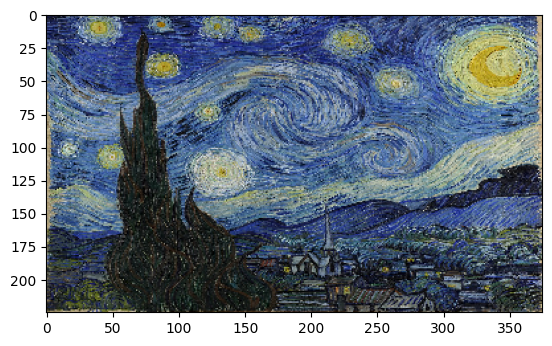

In [10]:
plt.imshow(image)

In [ ]:
type(image)

PIL.Image.Image

In [ ]:
image.mode, len(image.mode)

('RGB', 3)

In [ ]:
list(image.getdata())

In [11]:
image = tf.keras.preprocessing.image.img_to_array(image)

In [ ]:
type(image)

numpy.ndarray

In [12]:
image.shape

(225, 375, 3)

In [ ]:
image.min(), image.max()

(0.0, 255.0)

In [13]:
# image = image / 255
image = tf.keras.applications.inception_v3.preprocess_input(image)

In [14]:
image.min(), image.max() # 이래서 preprocess_input을 써야해.

(-1.0, 1.0)

## Getting the activations

In [ ]:
image.shape

(225, 375, 3)

In [15]:
image_batch = tf.expand_dims(image,axis = 0)
# np.expand_dims 도 가능

In [16]:
image_batch.shape

TensorShape([1, 225, 375, 3])

In [17]:
activations = deep_dream_model.predict(image_batch)

1/1 [==============================] - 2s 2s/step


In [18]:
deep_dream_model.outputs

[<KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed3')>,
 <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed5')>]

In [19]:
len(activations)

2

In [20]:
activations[0].shape, activations[1].shape

((1, 12, 21, 768), (1, 12, 21, 768))

## Calculating the loss

In [37]:
def calculate_loss(image,network):
    image_batch = tf.expand_dims(image, axis= 0)
    # activations = network.predict(image_batch)
    activations = network(image_batch)

    # print(image_batch.shape)
    losses = []
    for act in activations :
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    # print(losses)
    # print(np.shape(losses))
    # print(tf.reduce_sum(losses))

    return tf.reduce_sum(losses)

In [41]:
loss = calculate_loss(image,deep_dream_model)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.61807656>

## Gradient ascent (경사 상승법)


In [38]:
@tf.function
def deep_dream(network,image,learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image) # 변수를 저장한는? 방법 안하면 잃어버려
        loss = calculate_loss(image,network)
    gradients = tape.gradient(loss, image) # derivate
    gradients /= tf.math.reduce_std(gradients)
    # 딥드림에서는 가중치 갱신이 아닌 픽셀 갱신
    image = image + gradients * learning_rate
    image = tf.clip_by_value(image, -1, 1)

    return loss, image

In [39]:
def inverse_transform(image):
    image = 255 * (image + 1.0) /2.0
    return tf.cast(image,tf.uint8)

In [46]:
def run_deep_dream(network, image, epochs, learning_rate):
    for epoch in range(epochs):
        loss, image = deep_dream(network,image, learning_rate)

        if epoch % 20 == 0 :
            plt.figure(figsize  =(12,12))
            plt.imshow(inverse_transform(image))
            plt.show()
            print(f'Epoch {epoch}, loss {loss}')

## Generating images

In [35]:
image.shape, type(image)

((225, 375, 3), numpy.ndarray)

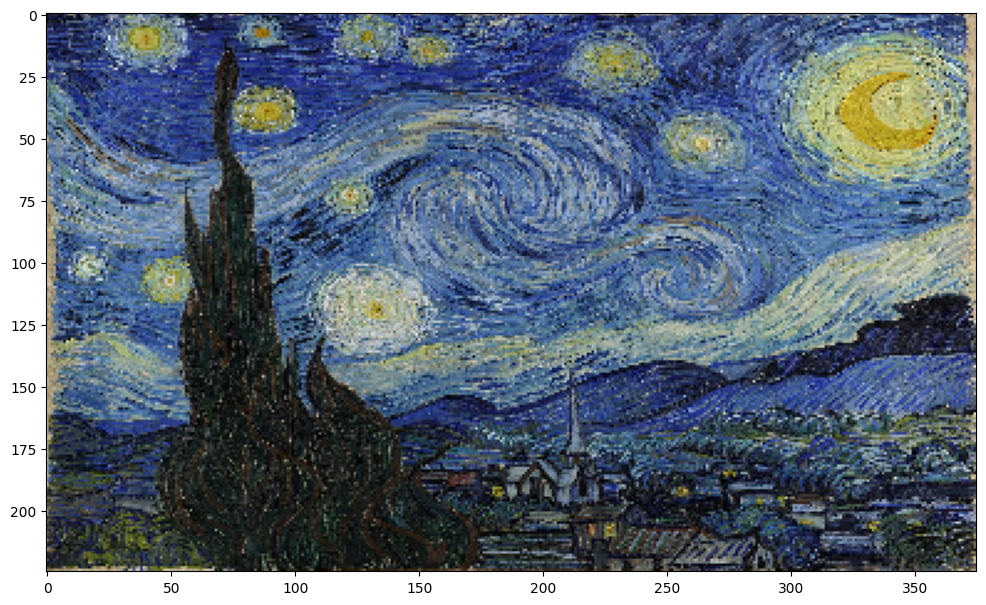

Epoch 0, loss 0.6180765628814697


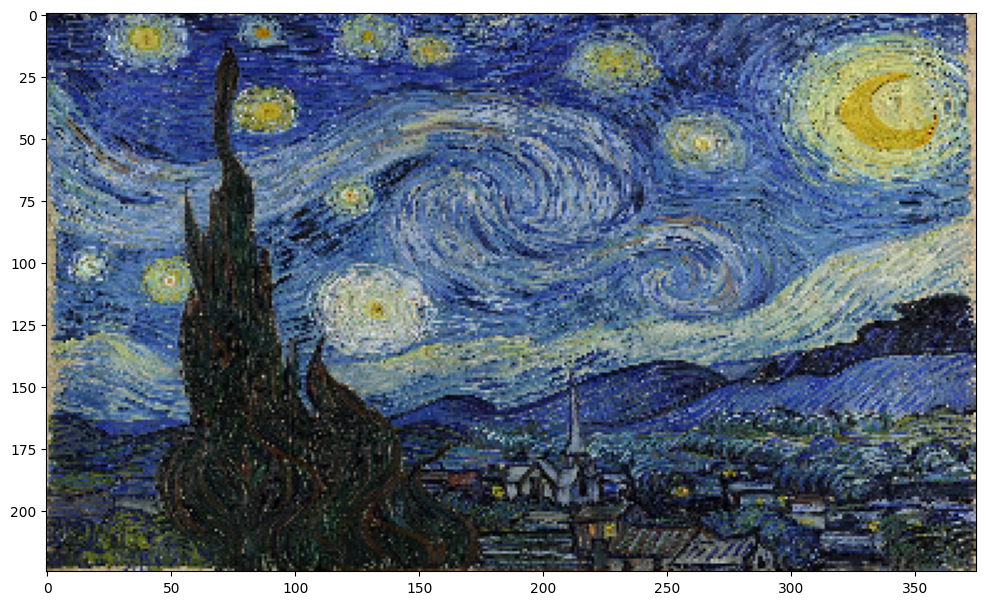

Epoch 20, loss 0.8581323623657227


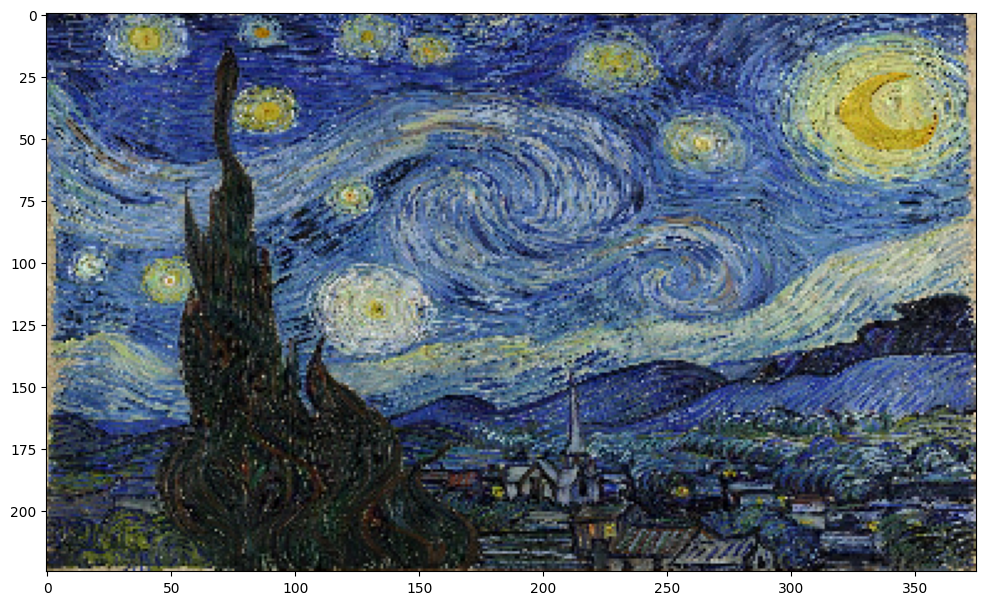

Epoch 40, loss 1.0487438440322876


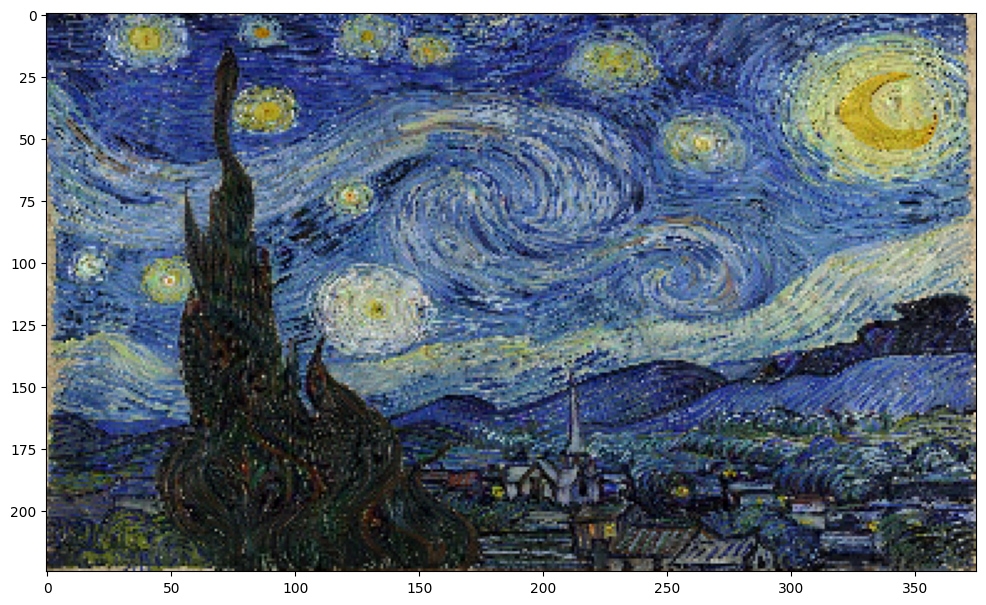

Epoch 60, loss 1.1982111930847168


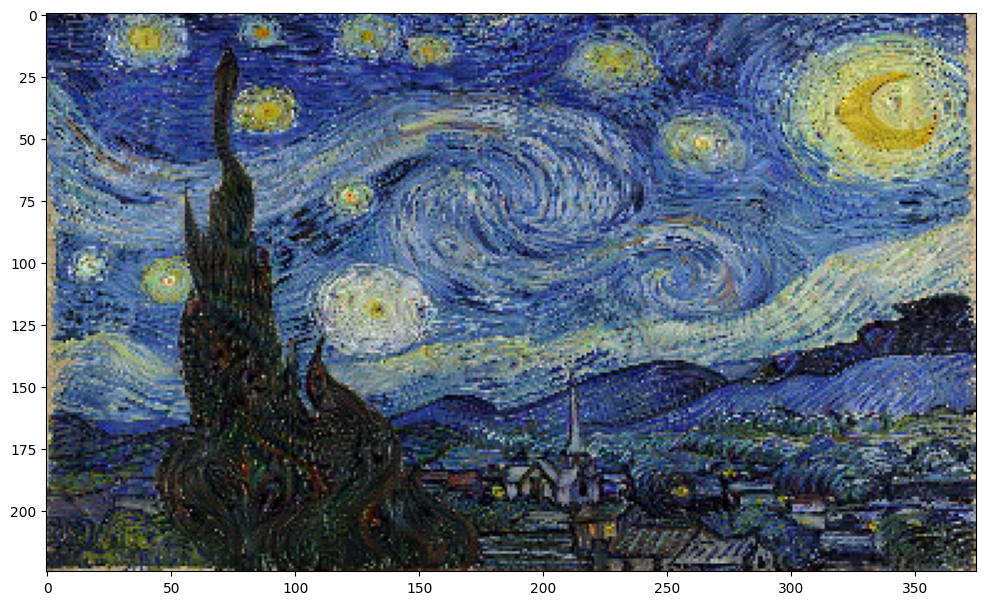

Epoch 80, loss 1.3175238370895386


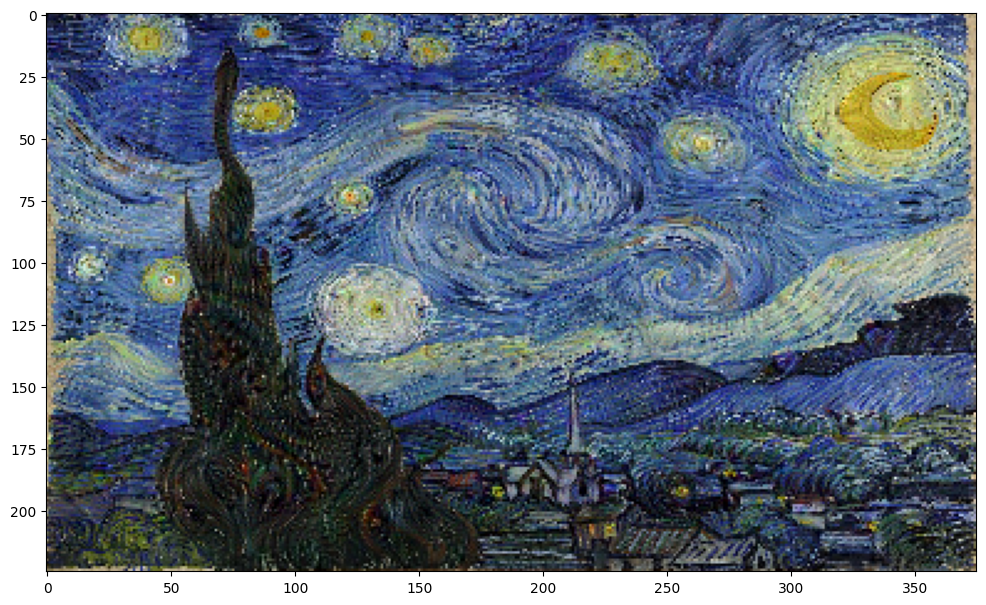

Epoch 100, loss 1.4153610467910767


In [47]:
run_deep_dream(network = deep_dream_model, image = image, epochs = 101,  learning_rate = 0.001)

## Homework